In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rayleigh
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SCALE  = 7.35
N      = 10000
N_BINS = 160

# 1 
Generar una muestra aleatoria de $10,000$ puntos de la distribución de $Rayleigh$ utilizando `scale = 7.53`.

In [2]:
def rayleigh_pdf(n_samples, vals, scale=SCALE):
    rx = np.linspace(0, max(vals), n_samples)
    return ((rx /SCALE**2) * np.exp(-rx**2 / (2 * SCALE**2)))

# Datos de entrada (features)
rayleigh_data = np.random.rayleigh(scale=SCALE, size=N)
# Datos reales (labels)
rx = np.linspace(0, max(rayleigh_data), N)
ray_pdf = rayleigh_pdf(N, rayleigh_data) 

rayleigh_data.shape, ray_pdf.shape

((10000,), (10000,))

# 2
Obtén $160$ puntos del histograma de tu muestra.

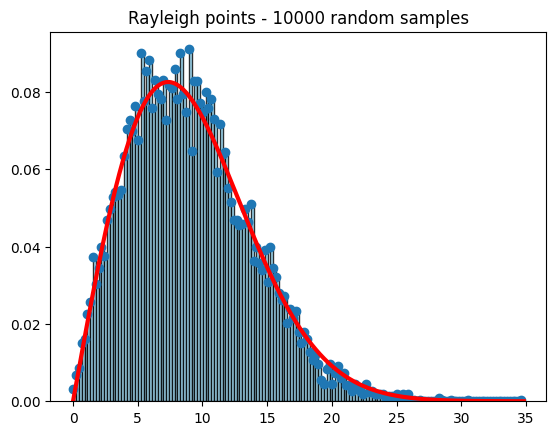

In [3]:
hist, bin_edges = np.histogram(rayleigh_data, bins=N_BINS, density=True)
plt.hist(rayleigh_data, bins=N_BINS, density=True, alpha=0.8, color='skyblue', edgecolor='black')
plt.scatter(bin_edges[:-1], hist)
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.title('Rayleigh points - 10000 random samples')
plt.show()

# 3
Divide los puntos en conjunto de entrenamiento y prueba (80-20).

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(bin_edges[:-1], hist, test_size=0.2, random_state=0)
X_train.shape, Y_train.shape, Y_test.shape, Y_test.shape

((128,), (128,), (32,), (32,))

# 4 
Realiza una regresión polinomial del conjunto de entrenamiento probando distintos grados
de polinomio. Calcula el sesgo y varianza para cada grado utilizado (Es posible que
tengas que dividir tu conjunto de entrenamiento en entrenamiento y validación). Imprime
los resultados en un dataframe de pandas: grado del polinomio, sesgo, varianza, $MAE,
MSE, R2$.

In [5]:
def reshape_data(X, y):
    return X.reshape(-1,1), y.reshape(-1,1)

def to_polynomial(X, deg):
    return PolynomialFeatures(degree=deg).fit_transform(X)

def compute_metrics(x_true_pol, y_true, y_hat):
    mae  = mean_absolute_error(y_true, y_hat)
    mse  = mean_squared_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    bias = np.mean(((x_true_pol) - np.mean(y_hat))**2)
    var  = np.var(y_hat)
    return mae, mse, r2, bias, var

def create_model_df(max_deg, normalized=False):
    cols = []
    if normalized:
        cols = ['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza', 'best_alpha']
    else:
        cols = ['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza']
    df = pd.DataFrame(columns=cols)
    
    model = RidgeCV(alphas=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]) if normalized else LinearRegression()
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol = to_polynomial(x_train, deg)
        x_test_pol  = to_polynomial(x_test, deg)
        fit = model.fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae, mse, r2, bias, var = compute_metrics(x_test_pol, y_test, y_hat)
        row = [deg, mae, mse, r2, bias, var, fit.alpha_] if normalized else [deg, mae, mse, r2, bias, var]
        df.loc[len(df.index)] = row
        
    return df

def polynomial_model_linear(max_deg):
    return create_model_df(max_deg)

In [6]:
df = polynomial_model_linear(10)
df

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,0.014802,0.000327,0.667550,2.025576e+02,0.000412
1,2.0,0.015363,0.000334,0.660200,8.938234e+04,0.000423
2,3.0,0.009394,0.000116,0.881591,5.199042e+07,0.000949
3,4.0,0.003748,0.000023,0.976098,3.493665e+10,0.000927
4,5.0,0.003876,0.000024,0.975172,2.567267e+13,0.000930
5,6.0,0.003278,0.000024,0.975884,2.004620e+16,0.000974
6,7.0,0.002851,0.000022,0.977312,1.635084e+19,0.000973
7,8.0,0.002843,0.000022,0.977129,1.377894e+22,0.000973
8,9.0,0.002892,0.000023,0.976913,1.190727e+25,0.000972
9,10.0,0.002995,0.000023,0.976510,1.049619e+28,0.000953


# 5
Repite el análisis del punto 4 pero utilizando regularización y validación cruzada.

In [7]:
def polynomial_model_ridgecv(max_deg):
    return create_model_df(max_deg, normalized=True)

In [8]:
df_2 = polynomial_model_ridgecv(10)
df_2

,grado_modelo,mae,mse,r2_score,sesgo,varianza,best_alpha
0,1.0,1.480212e-02,3.266183e-04,6.675320e-01,2.025576e+02,4.118767e-04,1.000000e+00
1,2.0,1.536352e-02,3.338379e-04,6.601831e-01,8.938234e+04,4.231699e-04,1.000000e+00
2,3.0,8.889014e-01,1.083654e+00,-1.102062e+03,5.199020e+07,1.131813e+00,1.000000e-07
3,4.0,3.731787e-03,2.341581e-05,9.761648e-01,3.493665e+10,9.440652e-04,1.000000e-01
4,5.0,7.663152e-01,8.359949e-01,-8.499675e+02,2.567267e+13,8.585806e-01,1.000000e-01
5,6.0,1.965789e+03,5.563462e+06,-5.663103e+09,2.004623e+16,5.408020e+06,1.000000e-01
6,7.0,6.756750e+11,6.715186e+23,-6.835454e+26,2.754416e+22,6.437328e+23,1.000000e-07
7,8.0,2.150213e+10,6.813231e+20,-6.935256e+23,1.406714e+22,6.426825e+20,1.000000e-02
8,9.0,1.201893e+13,2.083948e+26,-2.121272e+29,2.311149e+25,1.930032e+26,1.000000e-02
9,10.0,2.316455e+16,7.630141e+32,-7.766796e+35,7.105454e+31,6.922136e+32,1.000000e-02


# 6
Presenta tu mejor modelo polinomial y argumenta por qué es el mejor.

Consideraremos el mejor modelo basándonos primero en la métrica $R^2$. Dado que, para grados altos los datos comienzan a tener 
una dimensionalidad mayor, las métricas $MAE$ y $MSE$ nos dan valores poco representativos del verdadero error que el modelo presenta, mientras que la métrica elegida presenta información más útil y adecuada para evaluar un modelo polinomial. 

Podremos extraer el mejor modelo de ambos dataframes (modelos no regularizados y regularizados usando `RidgeCV`) buscando el máximo para la métrica `r2_score` y compararemos los mejores obtenidos entre ellos mismos para conocer el mejor. Sin embargo, esto no es suficiente para decidirnos entre estos dos; recordemos que buscamos un balance entre varianza y sesgo, por lo que elegiremos el modelo que tenga ambas métricas lo más balanceadas posible.

In [9]:
best_nonreg = df.iloc[df['r2_score'].argmax()]
best_reg    = df_2.iloc[df_2['r2_score'].argmax()]
best_models = pd.DataFrame([best_nonreg, best_reg], columns=df.columns)
best_models.insert(0, "categoria", ['non_reg', 'reg'])
best_models

,categoria,grado_modelo,mae,mse,r2_score,sesgo,varianza
6,non_reg,7.0,0.002851,0.000022,0.977312,1.635084e+19,0.000973
3,reg,4.0,0.003732,0.000023,0.976165,3.493665e+10,0.000944


Observamos que el modelo regularizado posee una vairanza y un sesgo mucho menor a los presentados por el modelo no regularizado, además de un valor de $R^2$ aceptable. Auque el modelo no regularizado presenta una puntuación perfecta, este posee valores muy altos en cuanto a sesgo y varianza, por lo que decidiremos utilizar el modelo regularizado.

In [23]:
def build_model(model_deg):
    x_train, y_train = reshape_data(X_train, Y_train)
    x_test, y_test   = reshape_data(X_test, Y_test)
    x_train_pol      = to_polynomial(x_train, model_deg)
    x_test_pol       = to_polynomial(x_test, model_deg)
    model = Ridge(alpha=best_reg['best_alpha']).fit(x_train_pol, y_train)
    print("mae: {}, mse: {}, r2_score: {}, sesgo: {}, varianza: {}"
          .format(*compute_metrics(x_test_pol, y_test, model.predict(x_test_pol))))
    return model

best_deg = int(best_models.iloc[0]['grado_modelo'])
best_model = build_model(best_deg)

mae: 0.0028467657444986986, mse: 2.2373097141223333e-05, r2_score: 0.9772262026345339, sesgo: 1.6350844487655528e+19, varianza: 0.000973216614963305


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.57878e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# 7
Utiliza la distribución de Rayleigh utilizando el estimador máximo verosímil: `scale = MLE` y compáralo con el modelo polinomial presentado en el punto 6, probando su rendimiento el el conjunto de prueba.

MAE: 0.0386969513741127,
MSE: 0.0022501505911624855,
R2: -1.4679569670606258,
Bias: 1.6350844487655528e+19,
Var: 0.000973216614963305


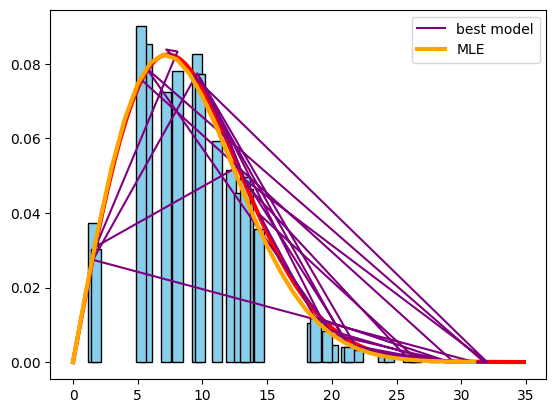

In [24]:
x_test, y_test = reshape_data(X_test, Y_test)
MLE = np.sqrt((np.sum(x_test**2)) / (2 * len(x_test)))

y_mle  = rayleigh_pdf(len(x_test), x_test, MLE)
x_test = to_polynomial(x_test, best_deg)
y_hat  = best_model.predict(x_test)

mae, mse, r2, bias, var = compute_metrics(x_test, y_mle, y_hat)

print(f"MAE: {mae},\nMSE: {mse},\nR2: {r2},\nBias: {bias},\nVar: {var}")
plt.bar(X_test, Y_test, color='skyblue', edgecolor='black')
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.plot(X_test, y_hat, label='best model', c='purple')
plt.plot(y_mle, label='MLE', c='orange', linewidth=3)
plt.legend()
plt.show()